---
# 101 Food Classes Mini Project
---

The goal is to beat the original **Food101 paper's** results with 10% of data. (https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/static/bossard_eccv14_food-101.pdf)

![image info](./images/1.png)

Start small, get a model working, see if your experiments work then gradually scale them up to where you want to go.

# What will this project contain:
- Training a feature extraction transfer learning model on 10% of the Food101 training data
- Fine-tuning feature extraction model
- Saving and loaded our trained model
- Evaluating the performance of Food Vision model trained on 10% of the training data
- Finding model's most wrong predictions
- Making predictions with our Food Vision model on custom images of food

In [1]:
!nvidia-smi

Wed Jul 17 16:03:08 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.70                 Driver Version: 560.70         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3060 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   53C    P8              9W /   90W |       0MiB /   6144MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [18]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [2]:
import datetime
print(f"Notebook last run (end-to-end): {datetime.datetime.now()}")

Notebook last run (end-to-end): 2024-07-17 16:03:26.119312


In [3]:
from helper_functions import *

# 101 Food Classes: Working with less data

The original Food101 dataset contains 1000 images per class (750 in the training set and 250 in the test set), totaling 101,000 images.

Instead of jumping directly into modeling with this extensive dataset, we'll continue our approach of experimentation by first evaluating how our previously effective models perform with just 10% of the training data.

This means we'll develop a model for each of the 101 food classes using 75 training images and evaluate its performance on 250 test images.

In [4]:
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent\test'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\apple_pie'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\baby_back_ribs'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\baklava'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\beef_carpaccio'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\beef_tartare'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\beet_salad'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\beignets'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\bibimbap'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\bread_pudding'.
There are 0 directories and 250 images in '10

The data comes in the common image classification data format of:

Example of file structure
```
10_food_classes_10_percent
├───train
│   ├───pizza
│   │   ├───123124.jpg
│   │   ├───123445.jpg
│   │   └───...
│   └───steak
│       ├───54321.jpg
│       ├───12345.jpg
│       └───...
└───test
    ├───pizza
    │   ├───111234.jpg
    │   ├───523234.jpg
    │   └───...
    └───steak
        ├───123124.jpg
        ├───123123.jpg
        └───...
```

Let's use the image_dataset_from_directory() function to turn our images and labels into a tf.data.Dataset, a TensorFlow datatype which allows for us to pass it directory to our model.

## Setup data inputs

In [5]:
import tensorflow as tf

In [6]:
IMG_SHAPE = (224,224)
# Train set
train_dir = "101_food_classes_10_percent/train/"
train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                 label_mode="categorical",
                                                                 image_size=IMG_SHAPE)
# Test set
test_dir = "101_food_classes_10_percent/test/"
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode = "categorical",
                                                                image_size= IMG_SHAPE,
                                                                shuffle=False) # don't shuffle test data for prediction analysis

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


### Train a  model with transfer learning on 10% of 101 food classes

More specifically, our goal will be to see if we can beat the baseline from original Food101 paper (50.76% accuracy on 101 classes) with 10% of the training data and the following modelling setup:

- A `ModelCheckpoint` callback to save our progress during training, this means we could experiment with further training later without having to train from scratch every time
Data augmentation built right into the model
- A headless (no top layers) `EfficientNetB0` architecture from `tf.keras.applications` as our base model
- A `Dense` layer with 101 hidden neurons (same as number of food classes) and softmax activation as the output layer
- Categorical crossentropy as the loss function since we're dealing with more than two classes
- The Adam optimizer with the default settings
- Fitting for 5 full passes on the training data while evaluating on 15% of the test data

## Creating ModelCheckpoint

In [7]:
checkpoint_path = "101_classes_10_percent_data_model_checkpoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True,
                                                         save_best_only=True,
                                                         monitor="val_accuracy")

## Creating Data Augmentation layer

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

In [9]:
data_augmentation = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomWidth(0.2),
    layers.RandomHeight(0.2),
    layers.RandomZoom(0.2)
], name = "data_augmented_layer")

## Creating Functional API model

In [11]:
len(train_data.class_names)

101

In [12]:
# Setup base model and freeze all layers
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
base_model.trainable=False

# Set up model architecture with trainable top layers
inputs = layers.Input(shape = (224,224,3), name = "input_layer")
x = data_augmentation(inputs)
x = base_model(x, training = False)
x = layers.GlobalAveragePooling2D(name = "global_average_pool_layer")(x)
outputs = layers.Dense(len(train_data.class_names), activation = "softmax", name = "output_layers")(x)
model = tf.keras.Model(inputs,outputs)

In [13]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmented_layer (Seque  (None, 224, 224, 3)      0         
 ntial)                                                          
                                                                 
 efficientnetv2-b0 (Function  (None, None, None, 1280)  5919312  
 al)                                                             
                                                                 
 global_average_pool_layer (  (None, 1280)             0         
 GlobalAveragePooling2D)                                         
                                                                 
 output_layers (Dense)       (None, 101)               129381    
                                                             

## Compile the model

In [14]:
model.compile(loss = "categorical_crossentropy",
              optimizer = "Adam", # default learning rate 0.001
              metrics=["accuracy"])

## Fit the model

The command `tf.get_logger().setLevel('ERROR')` sets TensorFlow's logging level to display only error messages, suppressing warnings and informational messages.

In [16]:
tf.get_logger().setLevel('ERROR')

In [17]:
history_all_classes_10_percent = model.fit(train_data,
                                           epochs=5,
                                           validation_data=test_data,
                                           validation_steps=int(0.15*len(test_data)),#using only 15% of the data
                                           callbacks = [checkpoint_callback])

Epoch 1/5
237/237 [==============================] - 60s 251ms/step - loss: 2.5640 - accuracy: 0.4259 - val_loss: 2.2755 - val_accuracy: 0.4762
Epoch 2/5
237/237 [==============================] - 57s 240ms/step - loss: 2.1153 - accuracy: 0.5046 - val_loss: 2.0418 - val_accuracy: 0.5064
Epoch 3/5
237/237 [==============================] - 57s 242ms/step - loss: 1.8805 - accuracy: 0.5426 - val_loss: 1.9433 - val_accuracy: 0.5087
Epoch 4/5
237/237 [==============================] - 57s 240ms/step - loss: 1.7125 - accuracy: 0.5827 - val_loss: 1.8248 - val_accuracy: 0.5363
Epoch 5/5
237/237 [==============================] - 58s 244ms/step - loss: 1.5913 - accuracy: 0.6051 - val_loss: 1.7843 - val_accuracy: 0.5416


## Evaluate model

In [19]:
result_feature_extraction = model.evaluate(test_data)
result_feature_extraction

790/790 [==============================] - 45s 57ms/step - loss: 1.5946 - accuracy: 0.5800


[1.5946193933486938, 0.5800396203994751]

It looks like we just beat our baseline (the results from the original Food101 paper) with 10% of the data! That's the power of deep learning and more precisely, transfer learning: leveraging what one model has learned on another dataset for our own dataset.

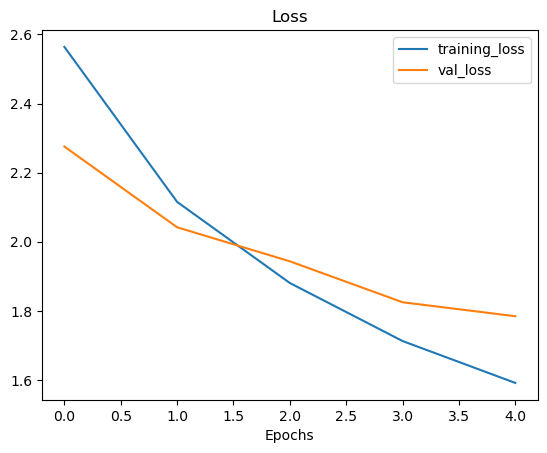

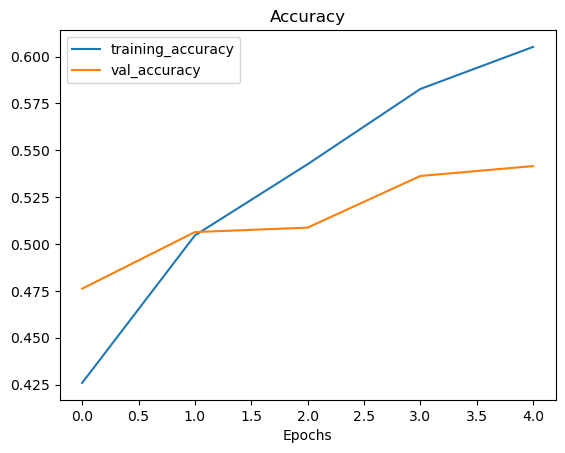

In [20]:
plot_loss_curves(history_all_classes_10_percent)

The two curves should be very similar to each other, if not, there may be some overfitting or underfitting.

## Fine - tuning

In [22]:
#Unfreeze all of the layers in the base model
base_model.trainable = True

# Refreeze all except for the 5 last 5
for layer in base_model.layers[:-5]:
    layer.trainable = False

## Recompile the model with lower learing rate

In [26]:
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-4), # 0.0001 - 10x lower than default 
              metrics=['accuracy'])

### What layers in the model are trainable?

In [27]:
for layer_number, layer in enumerate(model.layers):
    print(layer_number, layer.name, layer.trainable)

0 input_layer True
1 data_augmented_layer True
2 efficientnetv2-b0 True
3 global_average_pool_layer True
4 output_layers True


### Which layer in efficientnetv2-b0 are trainable?

In [28]:
for layer_number, layer in enumerate(base_model.layers):
    print(layer_number, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block2a_expand_conv False
10 block2a_expand_bn False
11 block2a_expand_activation False
12 block2a_project_conv False
13 block2a_project_bn False
14 block2b_expand_conv False
15 block2b_expand_bn False
16 block2b_expand_activation False
17 block2b_project_conv False
18 block2b_project_bn False
19 block2b_drop False
20 block2b_add False
21 block3a_expand_conv False
22 block3a_expand_bn False
23 block3a_expand_activation False
24 block3a_project_conv False
25 block3a_project_bn False
26 block3b_expand_conv False
27 block3b_expand_bn False
28 block3b_expand_activation False
29 block3b_project_conv False
30 block3b_project_bn False
31 block3b_drop False
32 block3b_add False
33 block4a_expand_conv False
34 block4a_expand_bn False
35 block4a_expand_activation False
36 block4a_dwconv2 Fals

## Fit the model

In [29]:
initial_epochs = 5
fine_tuned_epochs = initial_epochs + 5

In [30]:
history_all_classes_10_percent_fine_tune = model.fit(train_data,
                                                     epochs=fine_tuned_epochs,
                                                     validation_data= test_data,
                                                     validation_steps= int(0.15* len(test_data)),
                                                     initial_epoch=history_all_classes_10_percent.epoch[-1])

Epoch 5/10
237/237 [==============================] - 59s 217ms/step - loss: 1.4064 - accuracy: 0.6455 - val_loss: 1.7865 - val_accuracy: 0.5305
Epoch 6/10
237/237 [==============================] - 51s 215ms/step - loss: 1.3219 - accuracy: 0.6583 - val_loss: 1.7840 - val_accuracy: 0.5291
Epoch 7/10
237/237 [==============================] - 53s 222ms/step - loss: 1.2696 - accuracy: 0.6632 - val_loss: 1.7846 - val_accuracy: 0.5326
Epoch 8/10
237/237 [==============================] - 53s 223ms/step - loss: 1.2184 - accuracy: 0.6756 - val_loss: 1.7699 - val_accuracy: 0.5347
Epoch 9/10
237/237 [==============================] - 53s 225ms/step - loss: 1.1933 - accuracy: 0.6801 - val_loss: 1.7561 - val_accuracy: 0.5410
Epoch 10/10
237/237 [==============================] - 53s 224ms/step - loss: 1.1536 - accuracy: 0.6944 - val_loss: 1.7464 - val_accuracy: 0.5445


## Evaluate the model

In [31]:
result_all_classes_10_percent_fine_tune = model.evaluate(test_data)
result_all_classes_10_percent_fine_tune

790/790 [==============================] - 43s 55ms/step - loss: 1.4728 - accuracy: 0.6069


[1.472834587097168, 0.6068910956382751]

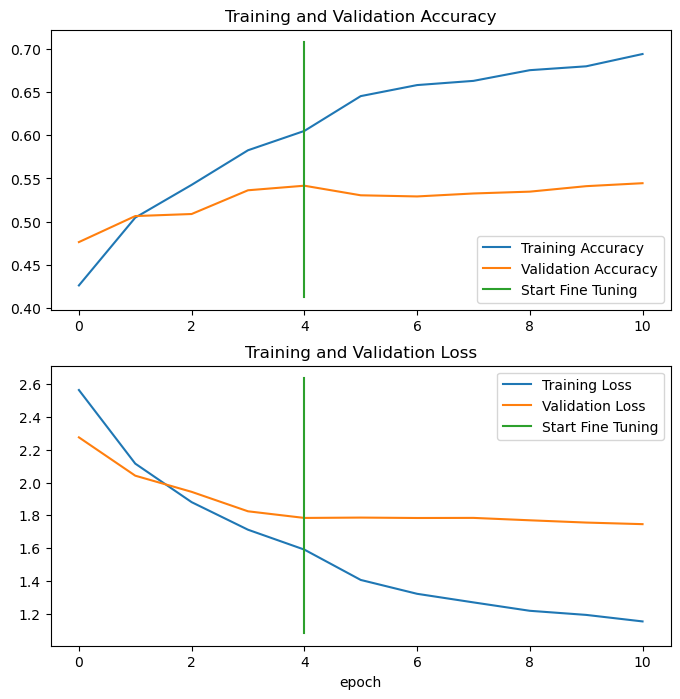

In [32]:
compare_historys(original_history=history_all_classes_10_percent, new_history= history_all_classes_10_percent_fine_tune, initial_epochs=5)

It appears that after fine-tuning, our model's training metrics improved significantly, but the validation metrics did not show the same improvement, indicating potential overfitting.

This is normal, as fine-tuning often leads to overfitting when the pre-trained model's data is similar to the custom data.

In our case, the pre-trained EfficientNetB0 model was trained on ImageNet, which includes many real-life pictures of food, similar to our dataset.

If feature extraction already performs well, the improvements from fine-tuning may not be as substantial, especially if your dataset is similar to the data the base model was pre-trained on.

# Saving the trained model

In [33]:
model.save("models/101_food_class_10_percent_saved_model")

In [36]:
loaded_model = tf.keras.models.load_model("models/101_food_class_10_percent_saved_model")

In [37]:
loaded_loss, loaded_acc = loaded_model.evaluate(test_data)

790/790 [==============================] - 47s 57ms/step - loss: 1.4728 - accuracy: 0.6069


In [38]:
loaded_loss, loaded_acc

(1.472834587097168, 0.6068910956382751)

# Make predictions with the trained model

In [39]:
pred_probs = loaded_model.predict(test_data, verbose = 1)

790/790 [==============================] - 42s 52ms/step


In [40]:
# How many predictions are there?
len(pred_probs)

25250

In [41]:
# What's the shape of pred_probs
pred_probs.shape

(25250, 101)

In [43]:
print(f"Number of prediction probabilities for sample 0: {len(pred_probs[0])}")
print(f"What prediction probability sample 0 looks like:\n {pred_probs[0]}")
print(f"The class with the highest predicted probability by the model for sample 0: {pred_probs[0].argmax()}")

Number of prediction probabilities for sample 0: 101
What prediction probability sample 0 looks like:
 [2.30122055e-03 5.26418662e-05 5.26819453e-02 2.42356663e-07
 3.62599785e-05 1.12501482e-04 1.73383505e-05 5.10574137e-06
 4.26952727e-04 4.47505823e-04 2.18579748e-06 3.19283281e-05
 8.00168855e-05 1.33516087e-05 2.53273267e-03 1.68335866e-02
 6.53025578e-04 4.31401713e-04 1.18101703e-03 5.22399496e-04
 7.10800814e-04 3.86163856e-06 3.50674090e-05 2.18476907e-05
 1.15017909e-04 3.99652781e-04 1.26803329e-03 5.39277835e-06
 5.13517065e-03 3.22183550e-05 9.30459692e-07 1.79710361e-04
 1.34262047e-03 2.50630310e-05 1.18069374e-03 2.82856363e-05
 4.75975045e-04 9.86749888e-04 2.31772624e-02 1.72657892e-04
 6.82505313e-04 6.45738968e-04 2.49206460e-05 7.82336938e-05
 7.30700995e-05 6.05499808e-05 9.22312378e-04 7.83255164e-05
 1.12562384e-05 3.03291045e-02 5.51730627e-04 1.50796797e-04
 9.89694819e-02 7.42917461e-03 1.17332070e-06 4.33974143e-04
 8.35253915e-04 5.64126123e-04 1.28394680e-

For each image tensor we pass to our model, because of the number of output neurons and activation function in the last layer `(layers.Dense(len(train_data_all_10_percent.class_names), activation="softmax")`, it outputs a prediction probability between **0** and **1** for all each of the **101 classes**.

And the index of the highest prediction probability can be considered what the model thinks is the most likely label. Similarly, the lower prediction probaiblity value, the less the model thinks that the target image is that specific class.

In [45]:
# Class predictions of each class
pred_classes = pred_probs.argmax(axis = 1)
pred_classes

array([ 85,   0,   0, ...,  56, 100,  52], dtype=int64)

We'll be able to compare these to the test dataset labels to further evaluate our model.

To get the test dataset labels we can unravel our test_data object (which is in the form of a tf.data.Dataset) using the unbatch() method.

Doing this will give us access to the images and labels in the test dataset. Since the labels are in one-hot encoded format, we'll take use the argmax() method to return the index of the label.

In [46]:
y_labels = []
for images, labels in test_data.unbatch(): # unbatch the test data and get images and labels
  y_labels.append(labels.numpy().argmax()) # append the index which has the largest value (labels are one-hot)
y_labels[:10] # check what they look like (unshuffled)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

# Evaluating our models predictions

A very simple evaluation is to use Scikit-Learn's `accuracy_score()` function which compares truth labels to predicted labels and returns an accuracy score.

In [47]:
from sklearn.metrics import accuracy_score

In [50]:
sklearn_accuracy = accuracy_score(y_labels,pred_classes)
sklearn_accuracy

0.6068910891089109

In [51]:
# Note: The following confusion matrix code is a remix of Scikit-Learn's 
# plot_confusion_matrix function - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Our function needs a different name to sklearn's plot_confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  ### Added: Rotate xticks for readability & increase font size (required due to such a large confusion matrix)
  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

In [52]:
class_names = train_data.class_names
class_names[:5]

['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare']

# Confusion Matrix

In [53]:
make_confusion_matrix(y_true = y_labels,
                      y_pred = pred_classes,
                      classes = class_names,
                      figsize = (100,100),
                      text_size = 20,
                      norm= False,
                      savefig=True)

Since we're working on a classification problem, we can further evaluate our model's predictions using Scikit-Learn's `classification_report()`function.

In [54]:
from sklearn.metrics import classification_report

print(classification_report(y_labels, pred_classes))

              precision    recall  f1-score   support

           0       0.33      0.22      0.26       250
           1       0.61      0.66      0.63       250
           2       0.66      0.50      0.57       250
           3       0.71      0.58      0.64       250
           4       0.54      0.40      0.46       250
           5       0.62      0.27      0.37       250
           6       0.79      0.78      0.78       250
           7       0.83      0.70      0.76       250
           8       0.26      0.60      0.37       250
           9       0.39      0.74      0.51       250
          10       0.61      0.38      0.47       250
          11       0.60      0.60      0.60       250
          12       0.78      0.57      0.66       250
          13       0.57      0.60      0.58       250
          14       0.51      0.60      0.55       250
          15       0.36      0.31      0.33       250
          16       0.61      0.60      0.60       250
          17       0.49    

The `classification_report()` function outputs the precision, recall, and f1-score for each class.

Here's a quick reminder:

- **Precision**: The proportion of true positives over the total number of predicted positives. Higher precision means fewer false positives (model predicts 1 when it should have predicted 0).
- **Recall**: The proportion of true positives over the total number of true positives and false negatives. Higher recall means fewer false negatives (model predicts 0 when it should have predicted 1).
- **F1 Score**: The harmonic mean of precision and recall, providing a single metric that balances both. A score of 1 is best, and 0 is worst.

While this output is helpful, it can be challenging to interpret with many classes.

First, we'll get the output of classification_report() as a dictionary by setting **output_dict=True**.

In [57]:
classification_report_dict = classification_report(y_labels, pred_classes, output_dict=True)
classification_report_dict

{'0': {'precision': 0.32934131736526945,
  'recall': 0.22,
  'f1-score': 0.2637889688249401,
  'support': 250.0},
 '1': {'precision': 0.6119402985074627,
  'recall': 0.656,
  'f1-score': 0.6332046332046332,
  'support': 250.0},
 '2': {'precision': 0.6596858638743456,
  'recall': 0.504,
  'f1-score': 0.5714285714285714,
  'support': 250.0},
 '3': {'precision': 0.7142857142857143,
  'recall': 0.58,
  'f1-score': 0.6401766004415012,
  'support': 250.0},
 '4': {'precision': 0.5372340425531915,
  'recall': 0.404,
  'f1-score': 0.4611872146118721,
  'support': 250.0},
 '5': {'precision': 0.6203703703703703,
  'recall': 0.268,
  'f1-score': 0.3743016759776536,
  'support': 250.0},
 '6': {'precision': 0.7918367346938775,
  'recall': 0.776,
  'f1-score': 0.7838383838383839,
  'support': 250.0},
 '7': {'precision': 0.8293838862559242,
  'recall': 0.7,
  'f1-score': 0.7592190889370932,
  'support': 250.0},
 '8': {'precision': 0.26455026455026454,
  'recall': 0.6,
  'f1-score': 0.3671970624235006,

To extract the f1-scores from the classification_report() output and store them in a dictionary, we'll create an empty dictionary called class_f1_scores and then loop through each item in the classification_report dictionary.

In [60]:
class_f1_scores = {}
# Loop through classification report items
for k, v in classification_report_dict.items():
  if k == "accuracy": # stop once we get to accuracy key
    break
  else:
    # Append class names and f1-scores to new dictionary
    class_f1_scores[class_names[int(k)]] = v["f1-score"]
class_f1_scores

{'apple_pie': 0.2637889688249401,
 'baby_back_ribs': 0.6332046332046332,
 'baklava': 0.5714285714285714,
 'beef_carpaccio': 0.6401766004415012,
 'beef_tartare': 0.4611872146118721,
 'beet_salad': 0.3743016759776536,
 'beignets': 0.7838383838383839,
 'bibimbap': 0.7592190889370932,
 'bread_pudding': 0.3671970624235006,
 'breakfast_burrito': 0.5081967213114754,
 'bruschetta': 0.4668304668304668,
 'caesar_salad': 0.6012024048096193,
 'cannoli': 0.6589861751152074,
 'caprese_salad': 0.5836575875486382,
 'carrot_cake': 0.5514705882352942,
 'ceviche': 0.3326226012793177,
 'cheese_plate': 0.6036217303822937,
 'cheesecake': 0.42105263157894735,
 'chicken_curry': 0.504424778761062,
 'chicken_quesadilla': 0.5813953488372093,
 'chicken_wings': 0.7291242362525459,
 'chocolate_cake': 0.5964214711729622,
 'chocolate_mousse': 0.4489795918367347,
 'churros': 0.7358916478555305,
 'clam_chowder': 0.7364016736401674,
 'club_sandwich': 0.659877800407332,
 'crab_cakes': 0.390625,
 'creme_brulee': 0.7095343

In [62]:
import pandas as pd

In [67]:
f1_scores = pd.DataFrame({"class_names":list(class_f1_scores.keys()),
                          "f1-score": list(class_f1_scores.values())}).sort_values("f1-score", ascending = False)
f1_scores.head()

class_names  f1-score
33              edamame  0.966862
63             macarons  0.893162
91  spaghetti_carbonara  0.857671
75                  pho  0.850895
65              mussels  0.845528

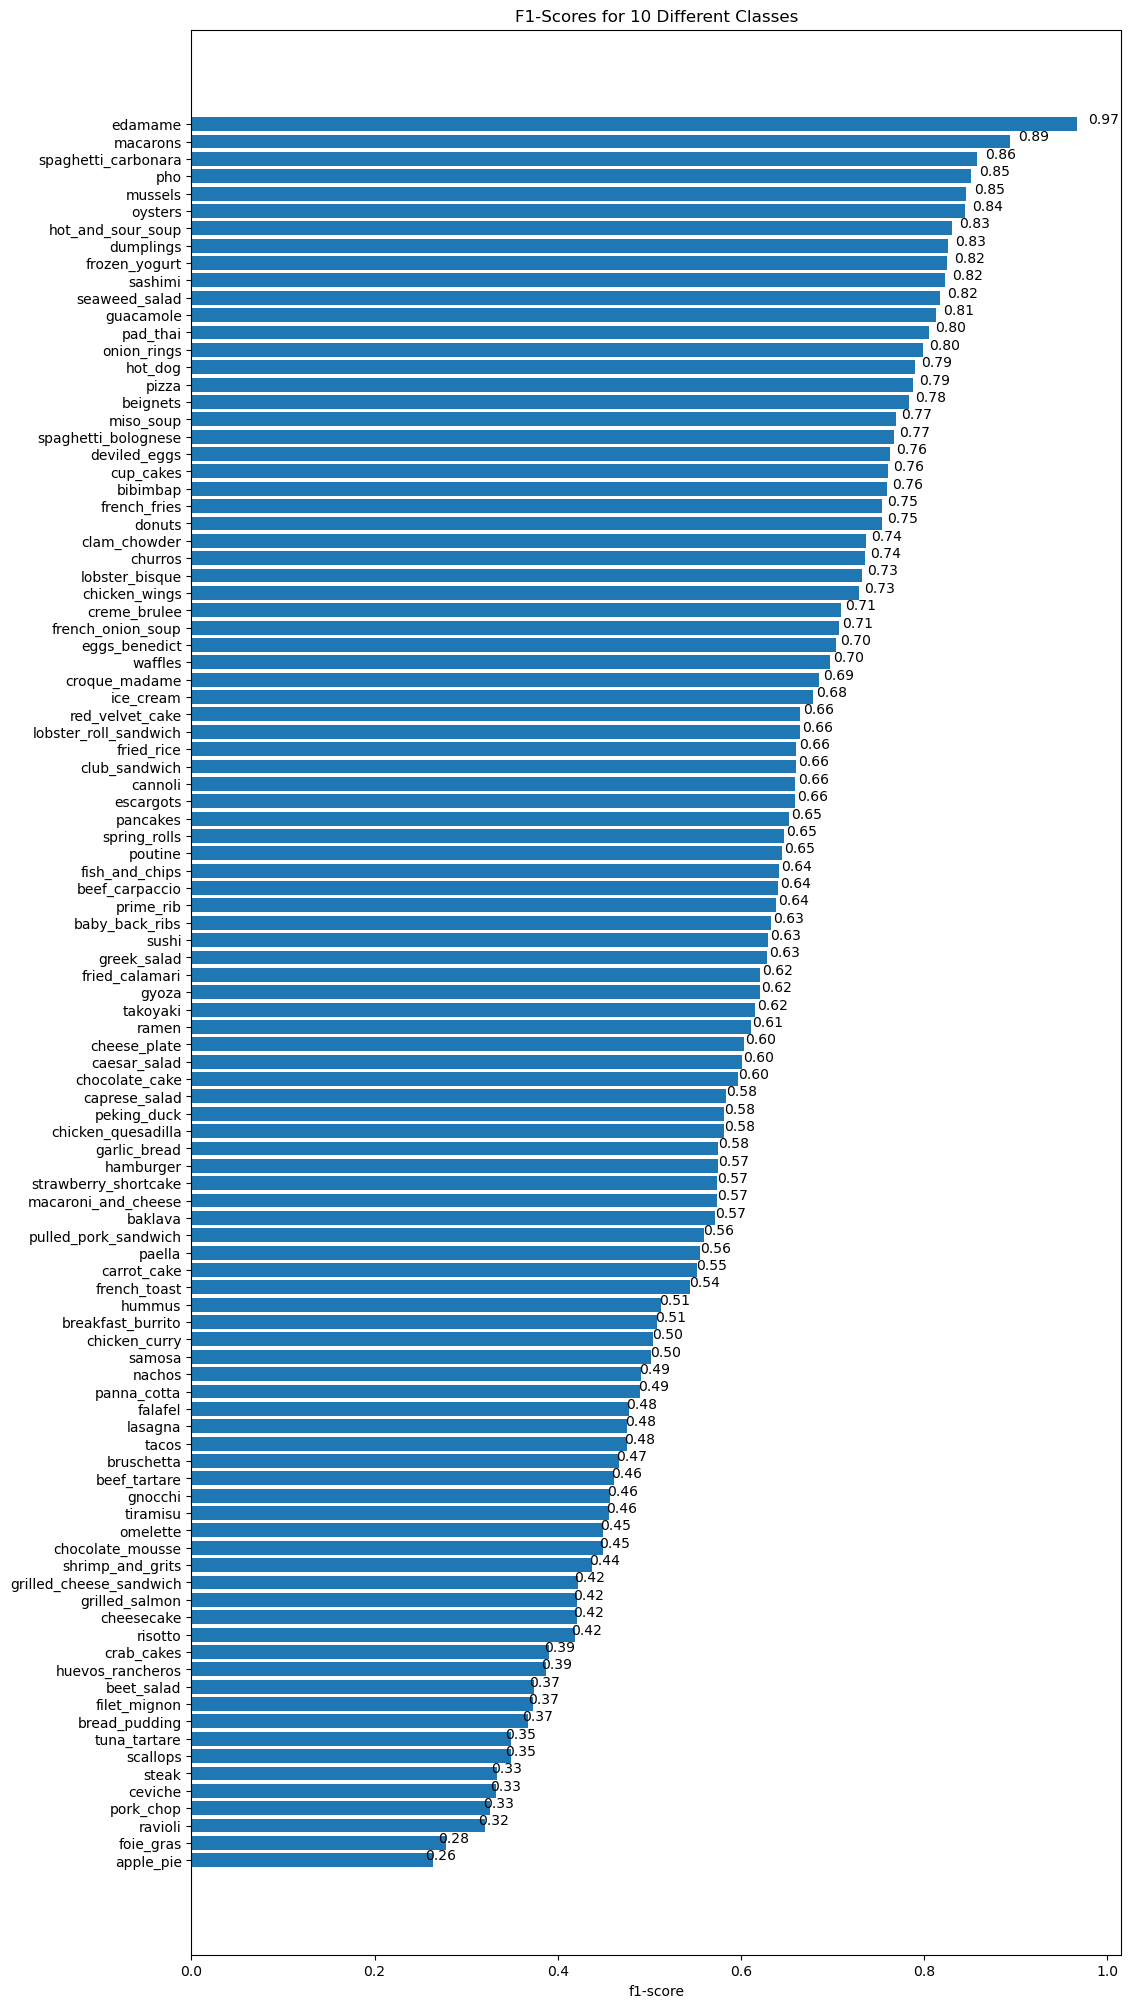

In [69]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 25))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1-score"].values)
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(list(f1_scores["class_names"]))
ax.set_xlabel("f1-score")
ax.set_title("F1-Scores for 10 Different Classes")
ax.invert_yaxis(); # reverse the order

def autolabel(rects): # Modified version of: https://matplotlib.org/examples/api/barchart_demo.html
  """
  Attach a text label above each bar displaying its height (it's value).
  """
  for rect in rects:
    width = rect.get_width()
    ax.text(1.03*width, rect.get_y() + rect.get_height()/1.5,
            f"{width:.2f}",
            ha='center', va='bottom')

autolabel(scores)

# Visualizing predictions on test images

Specifically, it'll:

- Read in a target image filepath using tf.io.read_file().
- Turn the image into a Tensor using tf.io.decode_image().
- Resize the image to be the same size as the images our model has been trained on (224 x 224) using tf.image.resize().
- Scale the image to get all the pixel values between 0 & 1 if necessary.

In [70]:
def load_and_prep_image(filename, img_shape=224, scale=True):
  """
  Reads in an image from filename, turns it into a tensor and reshapes into
  (224, 224, 3).

  Parameters
  ----------
  filename (str): string filename of target image
  img_shape (int): size to resize target image to, default 224
  scale (bool): whether to scale pixel values to range(0, 1), default True
  """
  # Read in the image
  img = tf.io.read_file(filename)
  # Decode it into a tensor
  img = tf.io.decode_image(img)
  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])
  if scale:
    # Rescale the image (get all values between 0 and 1)
    return img/255.
  else:
    return img

1/1 [==============================] - 0s 24ms/step


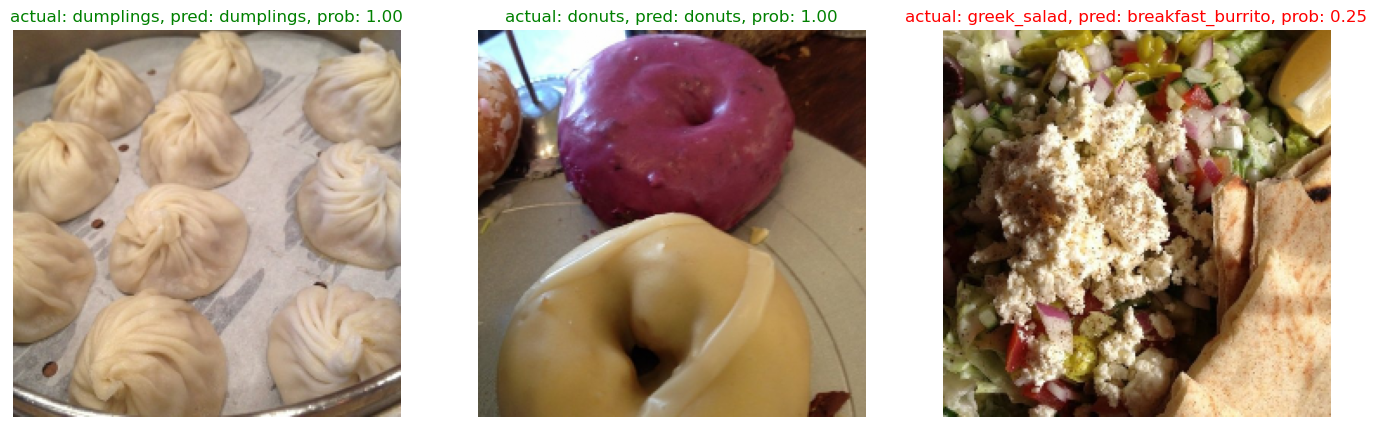

In [82]:
import os
import random

plt.figure(figsize=(17, 10))
for i in range(3):
  # Choose a random image from a random class 
  class_name = random.choice(class_names)
  filename = random.choice(os.listdir(test_dir + "/" + class_name))
  filepath = test_dir + class_name + "/" + filename

  # Load the image and make predictions
  img = load_and_prep_image(filepath, scale=False) # don't scale images for EfficientNet predictions
  pred_prob = model.predict(tf.expand_dims(img, axis=0)) # model accepts tensors of shape [None, 224, 224, 3]
  pred_class = class_names[pred_prob.argmax()] # find the predicted class 

  # Plot the image(s)
  plt.subplot(1, 3, i+1)
  plt.imshow(img/255.)
  if class_name == pred_class: # Change the color of text based on whether prediction is right or wrong
    title_color = "g"
  else:
    title_color = "r"
  plt.title(f"actual: {class_name}, pred: {pred_class}, prob: {pred_prob.max():.2f}", c=title_color)
  plt.axis(False);

# Finding the most wrong predictions

Steps:

- Get all of the image file paths in the test dataset using the list_files() method.
- Create a pandas DataFrame of the image filepaths, ground truth labels, prediction classes, max prediction probabilities, ground truth class names and predicted class names.
- Use our DataFrame to find all the wrong predictions (where the ground truth doesn't match the prediction).
- Sort the DataFrame based on wrong predictions and highest max prediction probabilities.
- Visualize the images with the highest prediction probabilities but have the wrong prediction.



In [88]:
filepaths = []
for filepath in test_data.list_files("101_food_classes_10_percent/test/*/*.jpg", shuffle= False):
    filepaths.append(filepath.numpy())
filepaths

[b'101_food_classes_10_percent\\test\\apple_pie\\1011328.jpg',
 b'101_food_classes_10_percent\\test\\apple_pie\\101251.jpg',
 b'101_food_classes_10_percent\\test\\apple_pie\\1034399.jpg',
 b'101_food_classes_10_percent\\test\\apple_pie\\103801.jpg',
 b'101_food_classes_10_percent\\test\\apple_pie\\1038694.jpg',
 b'101_food_classes_10_percent\\test\\apple_pie\\1047447.jpg',
 b'101_food_classes_10_percent\\test\\apple_pie\\1068632.jpg',
 b'101_food_classes_10_percent\\test\\apple_pie\\110043.jpg',
 b'101_food_classes_10_percent\\test\\apple_pie\\1106961.jpg',
 b'101_food_classes_10_percent\\test\\apple_pie\\1113017.jpg',
 b'101_food_classes_10_percent\\test\\apple_pie\\116705.jpg',
 b'101_food_classes_10_percent\\test\\apple_pie\\1167170.jpg',
 b'101_food_classes_10_percent\\test\\apple_pie\\1174330.jpg',
 b'101_food_classes_10_percent\\test\\apple_pie\\1180600.jpg',
 b'101_food_classes_10_percent\\test\\apple_pie\\1235282.jpg',
 b'101_food_classes_10_percent\\test\\apple_pie\\1269202.jp

In [89]:
# 2. Create a dataframe out of current prediction data for analysis
import pandas as pd
pred_df = pd.DataFrame({"img_path": filepaths,
                        "y_true": y_labels,
                        "y_pred": pred_classes,
                        "pred_conf": pred_probs.max(axis=1), # get the maximum prediction probability value
                        "y_true_classname": [class_names[i] for i in y_labels],
                        "y_pred_classname": [class_names[i] for i in pred_classes]}) 
pred_df.head()

img_path  y_true  y_pred  \
0  b'101_food_classes_10_percent\\test\\apple_pie...       0      85   
1  b'101_food_classes_10_percent\\test\\apple_pie...       0       0   
2  b'101_food_classes_10_percent\\test\\apple_pie...       0       0   
3  b'101_food_classes_10_percent\\test\\apple_pie...       0       0   
4  b'101_food_classes_10_percent\\test\\apple_pie...       0       8   

   pred_conf y_true_classname y_pred_classname  
0   0.515363        apple_pie           samosa  
1   0.710276        apple_pie        apple_pie  
2   0.427082        apple_pie        apple_pie  
3   0.301033        apple_pie        apple_pie  
4   0.714842        apple_pie    bread_pudding

In [90]:
# 3. Is the prediction correct?
pred_df["pred_correct"] = pred_df["y_true"] == pred_df["y_pred"]
pred_df.head()

img_path  y_true  y_pred  \
0  b'101_food_classes_10_percent\\test\\apple_pie...       0      85   
1  b'101_food_classes_10_percent\\test\\apple_pie...       0       0   
2  b'101_food_classes_10_percent\\test\\apple_pie...       0       0   
3  b'101_food_classes_10_percent\\test\\apple_pie...       0       0   
4  b'101_food_classes_10_percent\\test\\apple_pie...       0       8   

   pred_conf y_true_classname y_pred_classname  pred_correct  
0   0.515363        apple_pie           samosa         False  
1   0.710276        apple_pie        apple_pie          True  
2   0.427082        apple_pie        apple_pie          True  
3   0.301033        apple_pie        apple_pie          True  
4   0.714842        apple_pie    bread_pudding         False

In [92]:
# 4. Get the top 100 wrong examples
top_100_wrong = pred_df[pred_df["pred_correct"] == False].sort_values("pred_conf", ascending=False)[:100]
top_100_wrong.head(10)    

img_path  y_true  y_pred  \
14482  b'101_food_classes_10_percent\\test\\hummus\\8...      57      51   
10880  b'101_food_classes_10_percent\\test\\fried_cal...      43      68   
18001  b'101_food_classes_10_percent\\test\\pancakes\...      72      67   
4836   b'101_food_classes_10_percent\\test\\chicken_q...      19       9   
11697  b'101_food_classes_10_percent\\test\\garlic_br...      46      35   
20067  b'101_food_classes_10_percent\\test\\pulled_po...      80      53   
9690   b'101_food_classes_10_percent\\test\\fish_and_...      38      20   
17908  b'101_food_classes_10_percent\\test\\paella\\3...      71      65   
8612   b'101_food_classes_10_percent\\test\\eggs_bene...      34      53   
5114   b'101_food_classes_10_percent\\test\\chicken_w...      20      38   

       pred_conf      y_true_classname   y_pred_classname  pred_correct  
14482   0.997869                hummus          guacamole         False  
10880   0.997334        fried_calamari        onion_rings         False  
18001   0.996876              pancakes           omelette         False  
4836    0.996810    chicken_quesadilla  breakfast_burrito         False  
11697   0.994649          garlic_bread          escargots         False  
20067   0.994350  pulled_pork_sandwich          hamburger         False  
9690    0.993322        fish_and_chips      chicken_wings         False  
17908   0.993194                paella            mussels         False  
8612    0.992624         eggs_benedict          hamburger         False  
5114    0.992444         chicken_wings     fish_and_chips         False

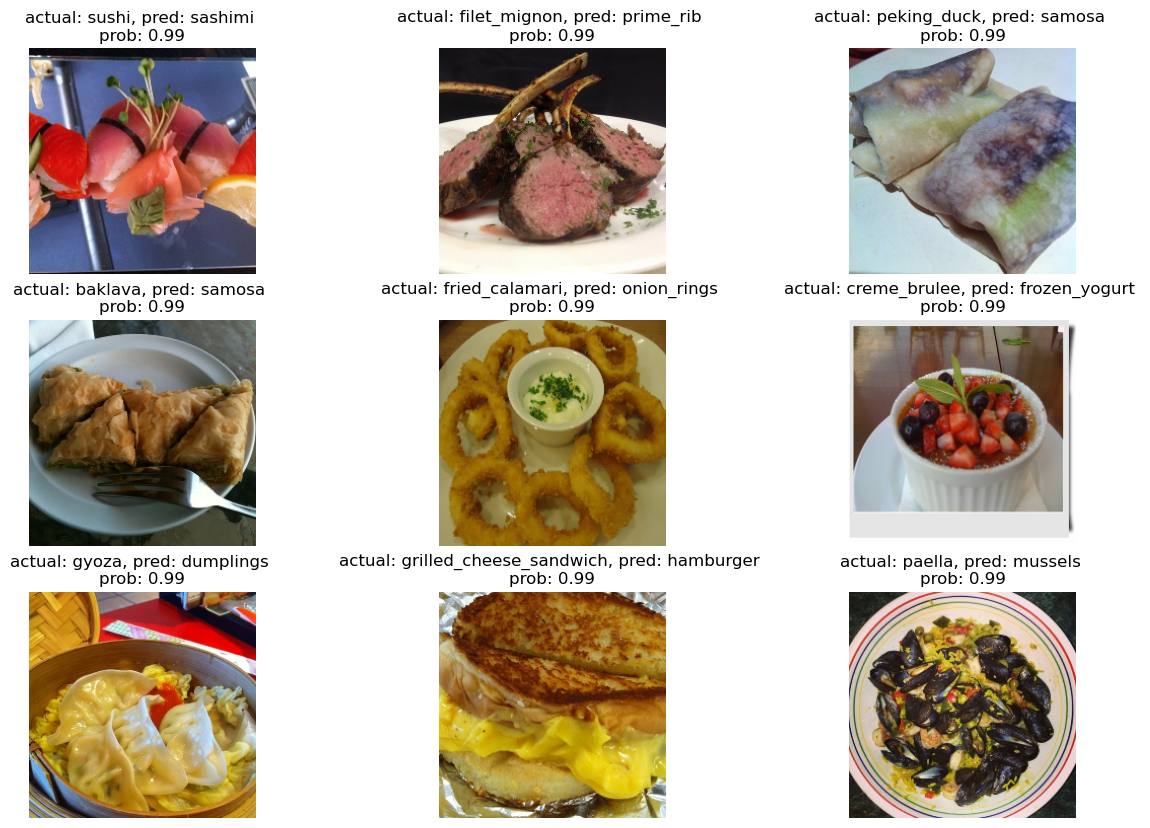

In [93]:
# 5. Visualize some of the most wrong examples
images_to_view = 9
start_index = 10 # change the start index to view more
plt.figure(figsize=(15, 10))
for i, row in enumerate(top_100_wrong[start_index:start_index+images_to_view].itertuples()): 
  plt.subplot(3, 3, i+1)
  img = load_and_prep_image(row[1], scale=True)
  _, _, _, _, pred_prob, y_true, y_pred, _ = row # only interested in a few parameters of each row
  plt.imshow(img)
  plt.title(f"actual: {y_true}, pred: {y_pred} \nprob: {pred_prob:.2f}")
  plt.axis(False)